In [2]:
!pip install psycopg2-binary

# Rendimento e emprego por estado

In [3]:
import psycopg2
import pandas as pd


dbname='dev'
user='admin'
password='Datadream2'
host='cubo-data-dream.463714952561.us-east-1.redshift-serverless.amazonaws.com'
port='5439'  # Use a porta correta do seu cluster Redshift

conn_string = f"dbname='{dbname}' user='{user}' host='{host}' port='{port}' password='{password}'"

conn = psycopg2.connect(conn_string)

# Cria um cursor
cursor = conn.cursor()

# Sua consulta SQL
query = """
SELECT
   rendimento_trabalho_.uf,
   avg(rendimento_trabalho_.renda_total) AS media_rendimento,
   count(*) AS total_empregados
FROM
   rendimento_trabalho_
WHERE
   rendimento_trabalho_.v5302 = 1
GROUP BY
   rendimento_trabalho_.uf;
"""

# Executa a consulta
cursor.execute(query)

# Busca os resultados e coloca em um DataFrame do pandas
colunas = [desc[0] for desc in cursor.description]
resultados = cursor.fetchall()
df = pd.DataFrame(resultados, columns=colunas)

# Fecha o cursor e a conexão
cursor.close()
conn.close()

# Salva o DataFrame em um arquivo CSV
caminho_do_arquivo_csv = './dados/visao_media_rendimento_emprego_por_estado.csv'  # Substitua pelo caminho desejado
df.to_csv(caminho_do_arquivo_csv, index=False)


/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

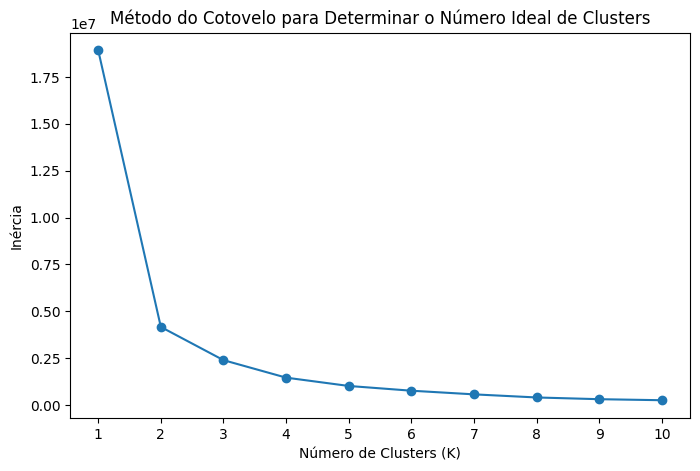

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Substitua isso pelo carregamento do seu conjunto de dados
# Por exemplo, df = pd.read_csv('seu_arquivo.csv')
df = pd.read_csv('./dados/visao_media_rendimento_emprego_por_estado.csv')

# Supondo que você esteja interessado em clusterizar com base em determinadas colunas
# Por exemplo, X = df[['coluna1', 'coluna2']]
X = df[['media_rendimento', 'total_empregados']]

# Lista para armazenar as inércias
inercias = []

# Intervalo de valores de K para testar
K_range = range(1, 11)

# Calcula a inércia para cada valor de K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

# Cria o gráfico de cotovelo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inercias, '-o')
plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.xticks(K_range)
plt.show()


/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


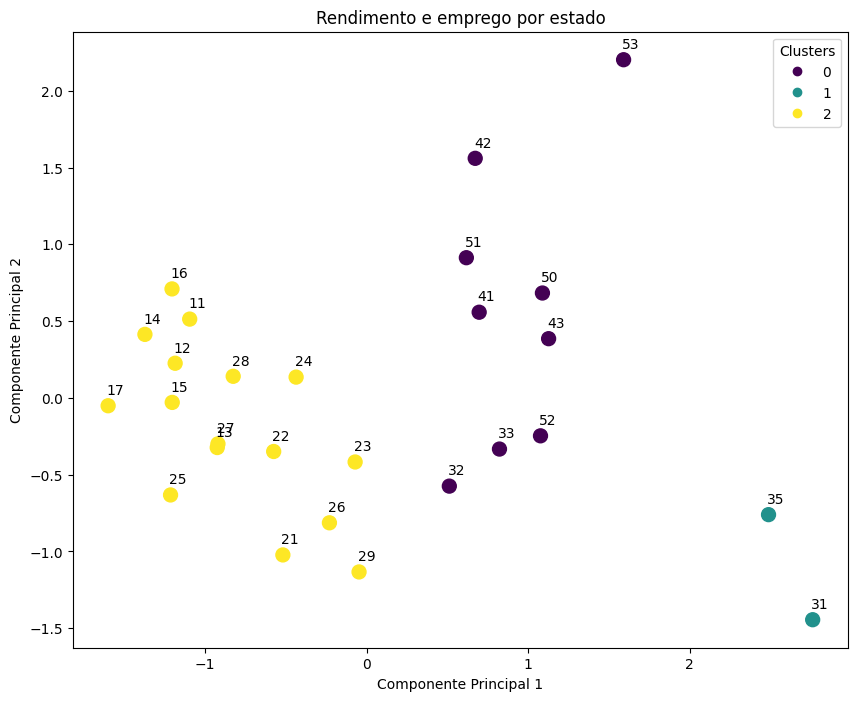

In [27]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Carregar os dados
# Substitua 'seu_arquivo.csv' pelo caminho para o arquivo CSV real
dados = pd.read_csv('./dados/visao_media_rendimento_emprego_por_estado.csv')

# Supondo que 'uf' seja uma característica categórica que você não deseja incluir na clusterização
# Selecionar as características numéricas
X = dados[['media_rendimento', 'total_empregados']]

# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para redução de dimensionalidade
pca = PCA(n_components=2)  # Reduzir para 2 componentes para visualização 2D
X_pca = pca.fit_transform(X_scaled)

# Aplicar K-means nos componentes principais
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)

# Adicionar os resultados do PCA e os clusters ao DataFrame
dados['PCA1'] = X_pca[:, 0]
dados['PCA2'] = X_pca[:, 1]
dados['Cluster'] = kmeans.labels_

# Visualizar os clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(dados['PCA1'], dados['PCA2'], c=dados['Cluster'], cmap='viridis', s=100)

# Definir o deslocamento dos rótulos
offset_x = 0.1  # Deslocamento na direção x
offset_y = 0.1  # Deslocamento na direção y

# Adicionar rótulos com a UF e o deslocamento
for i, uf in enumerate(dados['uf']):
    plt.text(dados['PCA1'].iloc[i] + offset_x, dados['PCA2'].iloc[i] + offset_y, str(uf), ha='right', va='center')

plt.title('Rendimento e emprego por estado')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [26]:
import pandas as pd
import numpy as np

# Supondo que 'melhores_cidades' é o seu DataFrame final com os dados do PCA e clusters
# Primeiro, criamos um novo DataFrame com as colunas necessárias
dados_para_enviar = dados[['uf', 'PCA1', 'PCA2']]

# Convertendo o DataFrame em um array NumPy
array_dados = dados_para_enviar.to_numpy()

# Preparar a conexão com o Redshift (exemplo genérico, ajuste conforme necessário)
import psycopg2

# Substitua pelos seus detalhes de conexão do Redshift
redshift_endpoint = "cubo-data-dream.463714952561.us-east-1.redshift-serverless.amazonaws.com"
redshift_user = "admin"
redshift_pass = "Datadream2"
redshift_dbname = "dev"
redshift_port = "5439"  # Porta padrão do Redshift


conn = psycopg2.connect(
    dbname=redshift_dbname,
    user=redshift_user,
    password=redshift_pass,
    port=redshift_port,
    host=redshift_endpoint
)

# Criar a tabela no Redshift, se ainda não existir
cur = conn.cursor()

# Inserir dados na tabela
for row in array_dados:
    cur.execute("""
        INSERT INTO tabela_rendimento (codigo_estado, eixo_x, eixo_y) VALUES (%s, %s, %s)
    """, (row[0], row[1], row[2]))

conn.commit()
cur.close()
conn.close()

# Gini Geral

/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

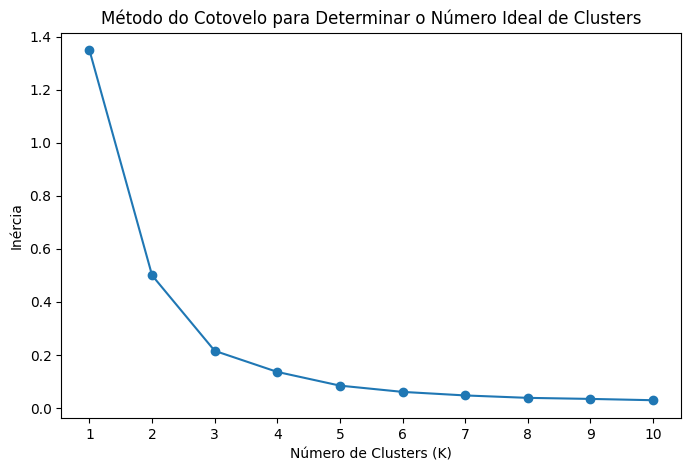

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Substitua isso pelo carregamento do seu conjunto de dados
# Por exemplo, df = pd.read_csv('seu_arquivo.csv')
df = pd.read_csv('./dados/gini_geral_s3.csv')

# Supondo que você esteja interessado em clusterizar com base em determinadas colunas
# Por exemplo, X = df[['coluna1', 'coluna2']]
X = df[['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011','2012', '2013', '2014', '2015','2016', '2017', '2018', '2019', '2020']]

# Lista para armazenar as inércias
inercias = []

# Intervalo de valores de K para testar
K_range = range(1, 11)

# Calcula a inércia para cada valor de K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

# Cria o gráfico de cotovelo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inercias, '-o')
plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.xticks(K_range)
plt.show()


/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


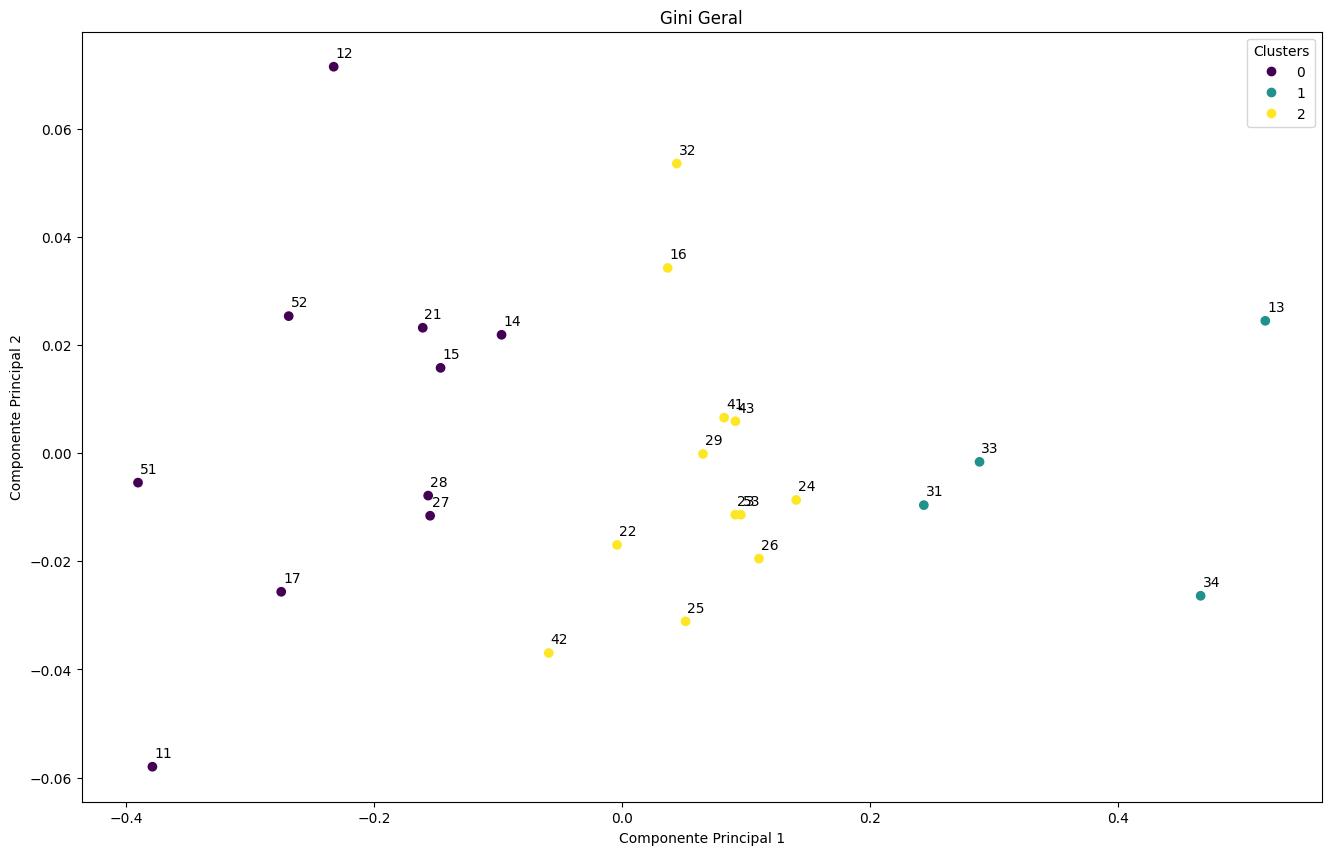

In [28]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv('./dados/gini_geral_s3.csv')

estados = df['Código']

X = df.drop(['Unidade da Federação', 'Código'], axis=1)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]

df['Cluster'] = kmeans.labels_

plt.figure(figsize=(16,10))
scatter = plt.scatter(df['pca-one'], df['pca-two'], c=df['Cluster'], cmap='viridis')

# Definir o deslocamento dos rótulos
offset_x = 0.01  # Deslocamento na direção x
offset_y = 0.003  # Deslocamento na direção y

# Adicionar anotações com deslocamento
for i, estado in enumerate(estados):
    plt.annotate(estado, 
                 (df['pca-one'][i] + offset_x, df['pca-two'][i] + offset_y),
                 textcoords="offset points", # Esta linha garante que o deslocamento é em pontos
                 xytext=(5,-5), # Estes são os valores de deslocamento em x e y
                 ha='right')

plt.xlabel('Componente Principal 1') 
plt.ylabel('Componente Principal 2')
plt.title('Gini Geral')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [24]:
import pandas as pd
import numpy as np

# Supondo que 'melhores_cidades' é o seu DataFrame final com os dados do PCA e clusters
# Primeiro, criamos um novo DataFrame com as colunas necessárias
dados_para_enviar = df[['Código', 'pca-one', 'pca-two']]

# Convertendo o DataFrame em um array NumPy
array_dados = dados_para_enviar.to_numpy()

# Preparar a conexão com o Redshift (exemplo genérico, ajuste conforme necessário)
import psycopg2

# Substitua pelos seus detalhes de conexão do Redshift
redshift_endpoint = "cubo-data-dream.463714952561.us-east-1.redshift-serverless.amazonaws.com"
redshift_user = "admin"
redshift_pass = "Datadream2"
redshift_dbname = "dev"
redshift_port = "5439"  # Porta padrão do Redshift


conn = psycopg2.connect(
    dbname=redshift_dbname,
    user=redshift_user,
    password=redshift_pass,
    port=redshift_port,
    host=redshift_endpoint
)

# Criar a tabela no Redshift, se ainda não existir
cur = conn.cursor()

# Inserir dados na tabela
for row in array_dados:
    cur.execute("""
        INSERT INTO tabela_gini_geral (codigo_estado, eixo_x, eixo_y) VALUES (%s, %s, %s)
    """, (row[0], row[1], row[2]))

conn.commit()
cur.close()
conn.close()

# Gini Industria

/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

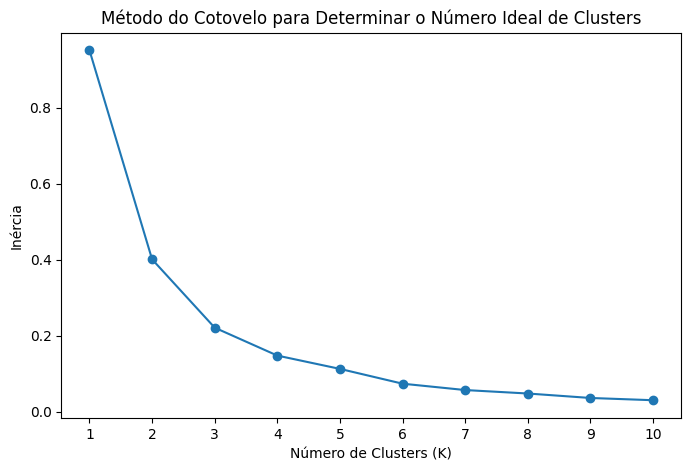

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Substitua isso pelo carregamento do seu conjunto de dados
# Por exemplo, df = pd.read_csv('seu_arquivo.csv')
df = pd.read_csv('./dados/gini_industria_s3.csv')

# Supondo que você esteja interessado em clusterizar com base em determinadas colunas
# Por exemplo, X = df[['coluna1', 'coluna2']]
X = df[['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011','2012', '2013', '2014', '2015','2016', '2017', '2018', '2019', '2020']]

# Lista para armazenar as inércias
inercias = []

# Intervalo de valores de K para testar
K_range = range(1, 11)

# Calcula a inércia para cada valor de K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

# Cria o gráfico de cotovelo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inercias, '-o')
plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.xticks(K_range)
plt.show()


/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


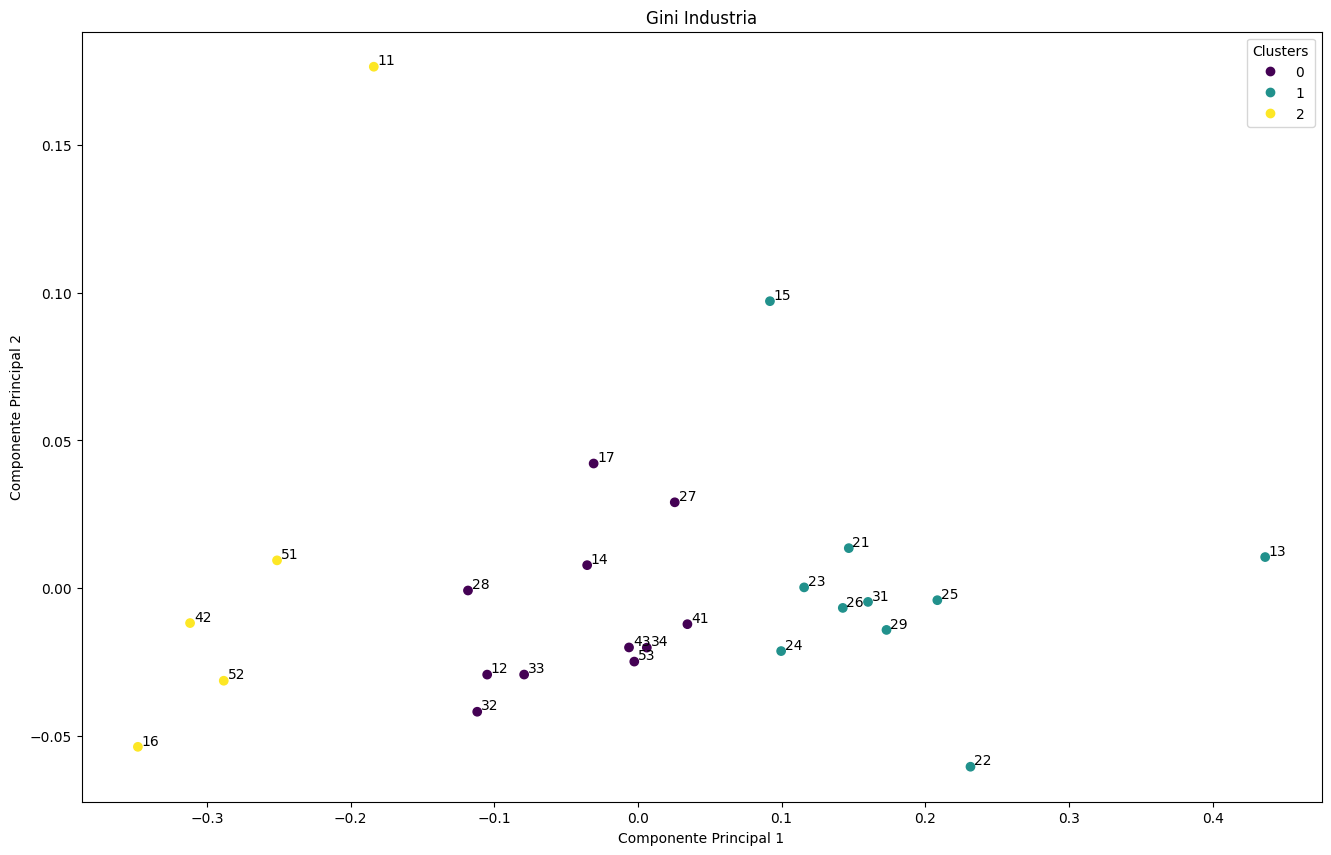

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv('./dados/gini_industria_s3.csv')

estados = df['Código']

X = df.drop(['Unidade da Federação', 'Código'], axis=1)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]

df['Cluster'] = kmeans.labels_

plt.figure(figsize=(16,10))
scatter = plt.scatter(df['pca-one'], df['pca-two'], c=df['Cluster'], cmap='viridis')

# Definir o deslocamento dos rótulos
offset_x = 0.01  # Deslocamento na direção x
offset_y = 0.003  # Deslocamento na direção y

# Adicionar anotações com deslocamento
for i, estado in enumerate(estados):
    plt.annotate(estado, 
                 (df['pca-one'][i] + offset_x, df['pca-two'][i] + offset_y),
                 textcoords="offset points", # Esta linha garante que o deslocamento é em pontos
                 xytext=(5,-5), # Estes são os valores de deslocamento em x e y
                 ha='right')

plt.xlabel('Componente Principal 1') 
plt.ylabel('Componente Principal 2')
plt.title('Gini Industria')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [16]:
import pandas as pd
import numpy as np

# Supondo que 'melhores_cidades' é o seu DataFrame final com os dados do PCA e clusters
# Primeiro, criamos um novo DataFrame com as colunas necessárias
dados_para_enviar = df[['Código', 'pca-one', 'pca-two']]

# Convertendo o DataFrame em um array NumPy
array_dados = dados_para_enviar.to_numpy()

# Preparar a conexão com o Redshift (exemplo genérico, ajuste conforme necessário)
import psycopg2

# Substitua pelos seus detalhes de conexão do Redshift
redshift_endpoint = "cubo-data-dream.463714952561.us-east-1.redshift-serverless.amazonaws.com"
redshift_user = "admin"
redshift_pass = "Datadream2"
redshift_dbname = "dev"
redshift_port = "5439"  # Porta padrão do Redshift


conn = psycopg2.connect(
    dbname=redshift_dbname,
    user=redshift_user,
    password=redshift_pass,
    port=redshift_port,
    host=redshift_endpoint
)

# Criar a tabela no Redshift, se ainda não existir
cur = conn.cursor()

# Inserir dados na tabela
for row in array_dados:
    cur.execute("""
        INSERT INTO tabela_gini_industria (codigo_estado, eixo_x, eixo_y) VALUES (%s, %s, %s)
    """, (row[0], row[1], row[2]))

conn.commit()
cur.close()
conn.close()

# PIB

/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

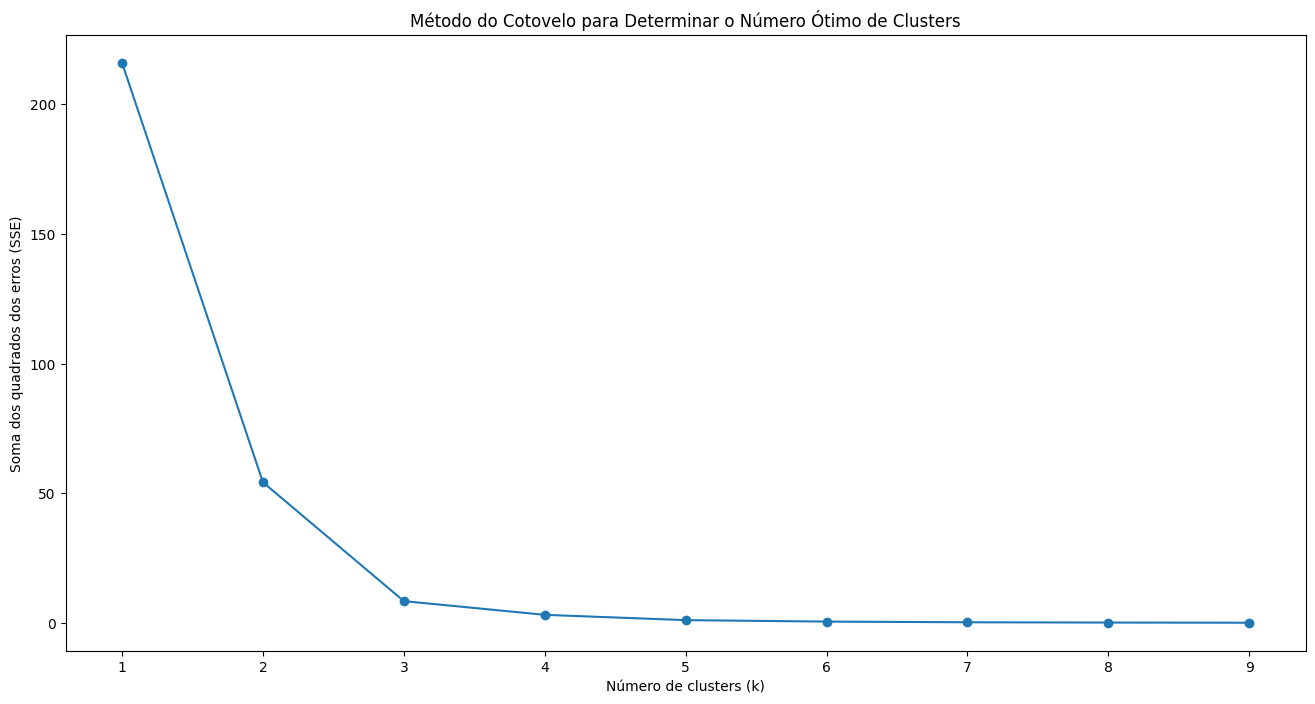

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Supondo que o arquivo CSV 'seu_arquivo.csv' contenha as colunas e os dados conforme o exemplo dado,
# o caminho do arquivo seria atualizado para o local onde o arquivo está armazenado.

# Carregar os dados do CSV
df = pd.read_csv('./dados/pib_s3.csv')

# Extrair a sigla do estado dos nomes dos municípios
df['Estado'] = df['Município'].str.extract(r'\((\w+)\)')

# Selecionar apenas as colunas numéricas
colunas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Encontrar a melhor cidade de cada estado com base na soma das colunas numéricas
melhores_cidades = df.groupby('Estado').apply(lambda x: x.loc[x[colunas_numericas].sum(axis=1).idxmax()])

# Remover colunas não numéricas para a análise de cluster
X = melhores_cidades[colunas_numericas]

# Normalizar os dados numéricos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcular a soma dos quadrados dentro dos clusters para diferentes valores de 'k'
sse = []
list_k = list(range(1, 10))

for k in list_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plotar o gráfico de cotovelo
plt.figure(figsize=(16, 8))
plt.plot(list_k, sse, '-o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos quadrados dos erros (SSE)')
plt.title('Método do Cotovelo para Determinar o Número Ótimo de Clusters')
plt.xticks(list_k)
plt.show()



/home/malumaia/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


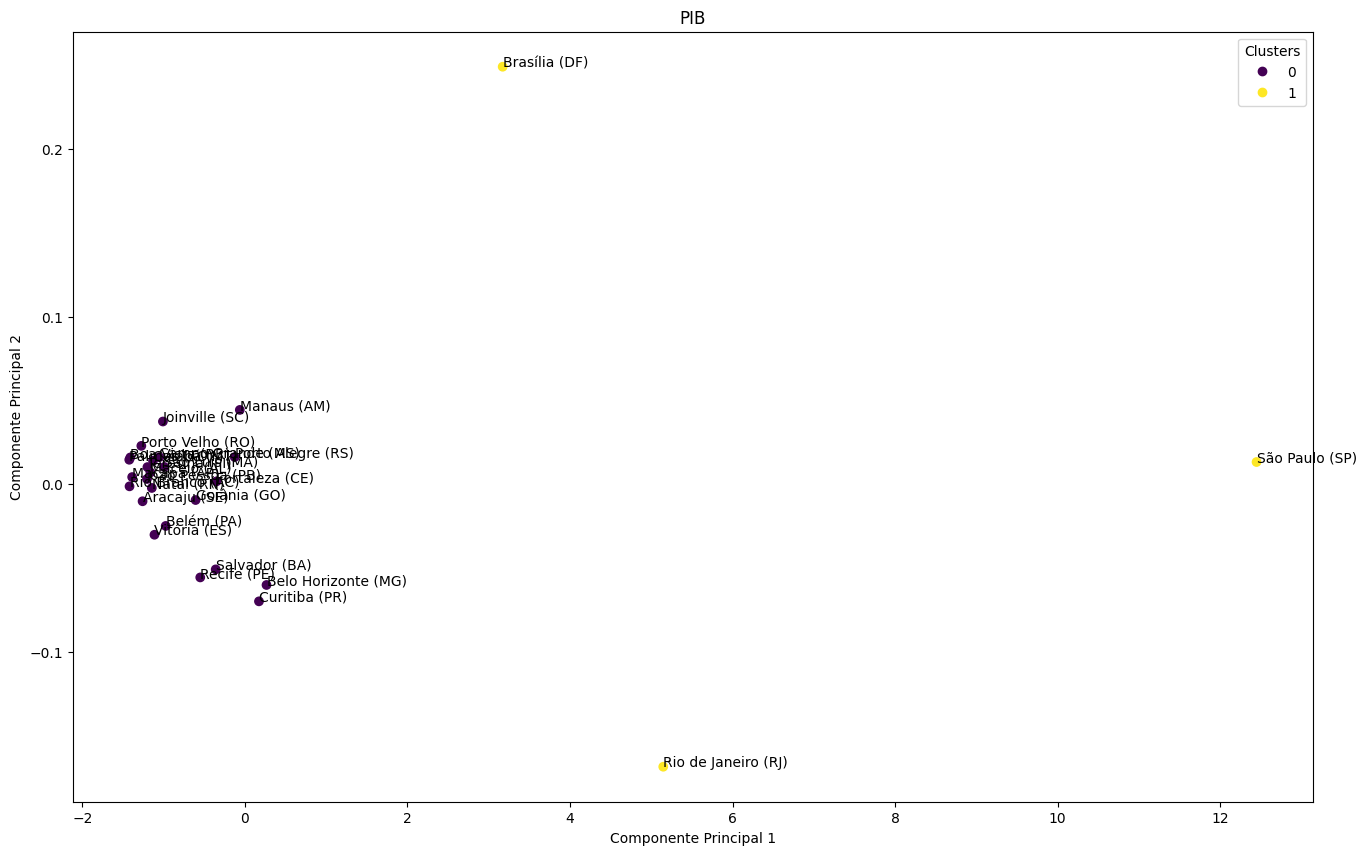

In [30]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Carregar os dados do CSV
df = pd.read_csv('./dados/pib_s3.csv')

# Assegurar que todos os dados na coluna 'Município' são strings
df['Município'] = df['Município'].astype(str)

# Tratar possíveis valores nulos
df = df.dropna(subset=['Município'])

# Extrair a sigla do estado dos nomes dos municípios
df['Estado'] = df['Município'].str.extract(r'\((\w+)\)')

# Selecione apenas as colunas numéricas para o agrupamento
colunas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Encontrar a cidade com o maior valor total para cada estado
melhores_cidades = df.groupby('Estado').apply(lambda x: x.loc[x[colunas_numericas].sum(axis=1).idxmax()]).reset_index(drop=True)

# Normalizar os dados numéricos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(melhores_cidades[colunas_numericas])

# Redução de dimensionalidade com PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Treinar o modelo K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_pca)

# Adicionar os resultados do PCA e os clusters ao DataFrame
melhores_cidades['pca-one'] = X_pca[:, 0]
melhores_cidades['pca-two'] = X_pca[:, 1]
melhores_cidades['Cluster'] = kmeans.labels_

# Plotar os clusters
plt.figure(figsize=(16, 10))
scatter = plt.scatter(melhores_cidades['pca-one'], melhores_cidades['pca-two'], c=melhores_cidades['Cluster'], cmap='viridis')

# Adicionar rótulos dos municípios
for i, municipio in enumerate(melhores_cidades['Município']):
    plt.annotate(municipio, (melhores_cidades['pca-one'][i], melhores_cidades['pca-two'][i]))

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PIB')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [13]:
import pandas as pd
import numpy as np

# Supondo que 'melhores_cidades' é o seu DataFrame final com os dados do PCA e clusters
# Primeiro, criamos um novo DataFrame com as colunas necessárias
dados_para_enviar = melhores_cidades[['Município', 'pca-one', 'pca-two']]

# Convertendo o DataFrame em um array NumPy
array_dados = dados_para_enviar.to_numpy()

# Preparar a conexão com o Redshift (exemplo genérico, ajuste conforme necessário)
import psycopg2

# Substitua pelos seus detalhes de conexão do Redshift
redshift_endpoint = "cubo-data-dream.463714952561.us-east-1.redshift-serverless.amazonaws.com"
redshift_user = "admin"
redshift_pass = "Datadream2"
redshift_dbname = "dev"
redshift_port = "5439"  # Porta padrão do Redshift


conn = psycopg2.connect(
    dbname=redshift_dbname,
    user=redshift_user,
    password=redshift_pass,
    port=redshift_port,
    host=redshift_endpoint
)

# Criar a tabela no Redshift, se ainda não existir
cur = conn.cursor()

# Inserir dados na tabela
for row in array_dados:
    cur.execute("""
        INSERT INTO tabela_cidades (nome_cidade, eixo_x, eixo_y) VALUES (%s, %s, %s)
    """, (row[0], row[1], row[2]))

conn.commit()
cur.close()
conn.close()
